# **Parcial 2 TAM**

# **2.1 Modelos y optimizaciones**

* **2.1.1 Naive bayes**

El modelo del naive bayes asume que las caracteristicas de los datos son independientes entre si, dejando la probabilidad posterior como:
$$p(A,x) =  \prod_{j=1}^{P} p(x_j|A)p(A)$$

La optimización se hace por máximo a posteriori
$$\hat{y} = \arg\max_{c} \prod_{j=1}^{P} p(x_j \mid A_c) p(A_c)$$

maximizando la probabilidad de pertenencia a la clase A

* **2.1.2 Logistic Regresor**

El modelo Logistic Regression utiliza la funcion sigmoide para predecir la probabilidad de pertenencia a una clase, esta dado por:
$$p(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + \exp\left(-(\mathbf{w}^\top \mathbf{x} + b)\right)}$$

# **2.2 Implementacion de modelos**

**Copiamos el preproceso del cuaderno guia (6_CVClasificacion_LFW.ipynb)**

In [3]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Class Prior Probabilities (Proportions):
[0.05512422 0.11180124 0.41149068 0.18322981 0.05978261 0.08462733
 0.0939441 ]
Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


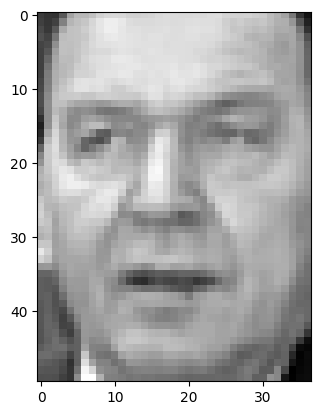

In [4]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
#Conteo de las imagenes para conocer el desbalance de datos
counter = Counter(lfw_people.target)
total_images = len(lfw_people.images)
#Visualizar el desbanlance
# Compute proportions
proportions = np.array([count / total_images for count in counter.values()])

# Print proportions
print("Class Prior Probabilities (Proportions):")
print(proportions)

# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [6]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


* **2.2.1 Implementación de los modelos con accuracy como score en el gridsearch**

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LogisticRegression as LR, SGDClassifier as SGDC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import DotProduct
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', NB())], #Pipeline1
       [('nor', MinMaxScaler()),
        ('cla', LR())], #Pipeline2
       [('nor', MinMaxScaler()),
        ('cla', SGDC())], #Pipeline3
       [('nor', MinMaxScaler()),
        ('cla', LDA())], #Pipeline4
       [('nor', MinMaxScaler()),
        ('cla', KNC())], #Pipeline5
       [('nor', MinMaxScaler()),
        ('cla', RF())], #Pipeline6
       [('nor', MinMaxScaler()),
        ('cla', SVC())], #Pipeline7
       [('nor', MinMaxScaler()),
        ('cla', GPC())]#Pipeline8
      ]
#Para el SVC los diferentes kernels tienen diferentes hiperparametros
#linear kernel (only C and shrinking are relevant)
param_grid_svc_linear = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['linear'],
    'cla__shrinking': [True, False]
}

#polynomial kernel (degree, gamma, and coef0 are relevant)
param_grid_svc_poly = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['poly'],
    'cla__degree': [2, 3, 4, 5],
    'cla__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'cla__coef0': [0.0, 0.1, 1.0],
    'cla__shrinking': [True, False]
}

#RBF kernel (gamma is relevant)
param_grid_svc_rbf = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['rbf'],
    'cla__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'cla__shrinking': [True, False]
}

#sigmoid kernel (gamma and coef0 are relevant)
param_grid_svc_sigmoid = {
    'cla__C': [0.001, 0.01, 0.1, 1],
    'cla__kernel': ['sigmoid'],
    'cla__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'cla__coef0': [0.0, 0.1, 1.0],
    'cla__shrinking': [True, False]
}

#Se combinan
param_grid_svc = [
    param_grid_svc_linear,
    param_grid_svc_poly,
    param_grid_svc_rbf,
    param_grid_svc_sigmoid
]

parameters = [{
              'cla__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],#Pipeline1 - hiperparametros
              },
              {
                'cla__C': [0.01, 0.1, 1],
                'cla__penalty': ['elasticnet'],#En lugar de probar l1 y l2 directamente, se pone l1ratio a 0 y a 1 para que los pruebe dentro de elasticnet
                'cla__solver': ['saga'],
                'cla__class_weight': [None, 'balanced'],
                'cla__l1_ratio': [0, 0.2, 0.5, 0.7, 1] #Pipeline2 - hiperparametros 
              },                                                                            
              {
                'cla__loss': ['hinge', 'log_loss', 'modified_huber'],
                'cla__alpha': [1e-4, 1e-3, 1e-2],
                'cla__penalty': ['elasticnet'],
                'cla__l1_ratio': [0, 0.2, 0.5, 0.7, 1],#En lugar de probar l1 y l2 directamente, se pone l1ratio a 0 y a 1 para que los pruebe dentro de elasticnet
                'cla__learning_rate': ['constant', 'optimal', 'invscaling'],
                'cla__eta0': [0.001, 0.01, 0.1],
                'cla__class_weight': [None, 'balanced'] #Pipeline3 - hiperparametros
              },
              {
                'cla__solver': ['svd', 'lsqr', 'eigen'],
                'cla__shrinkage': [None, 'auto', 1e-3, 1e-2, 1e-1],  # Only applies for 'lsqr' or 'eigen'
                'cla__priors': [None, proportions],
                'cla__n_components': [None, 2, 5]#Pipeline 4 - hiperparametros
              },
              {
                'cla__n_neighbors': [5, 9, 15, 31],
                'cla__weights': ['uniform', 'distance'],
                'cla__metric': ['minkowski'],
                'cla__p': [0.5, 1, 2, 4], 
                'cla__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']#Pipeline 5 - hiperparametros
              },
              {
                'cla__n_estimators': [1, 25, 50],
                'cla__max_depth': [None, 1, 10],
                'cla__min_samples_split': [2, 10, 20],
                'cla__min_samples_leaf': [1, 5, 10],
                'cla__max_features': ['sqrt', 'log2', None],
                'cla__bootstrap': [True, False],
                'cla__criterion': ['gini', 'entropy']#Pipeline 6 - hiperparametros
              },
                 param_grid_svc,
              {
                'cla__kernel': [
                            C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1)),
                            C(1.0, (1e-4, 1e1)) * RationalQuadratic(length_scale=1.0, alpha=1.0),
                            C(1.0, (1e-4, 1e1)) * DotProduct(),
                        ],
                'cla__optimizer': ['fmin_l_bfgs_b', 'sgd', None],
                'cla__n_restarts_optimizer': [0, 5, 10],
                'cla__multi_class': ['one_vs_rest', 'one_vs_one']
              }      
             ]

label_models = ['NaiveB','LogisticRegressor','SGD', 'LinearDisc', 'KNeighbors', 'RandomForest', 'SVC', 'GPClass']

In [ ]:
models = []
filename = 'results/lfw_models_acc'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=2)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

**Scores en CV**

In [ ]:
import seaborn as sns
label_models = ['KNeighbors']
model_names = label_models  # List of model names (as in your code)
model_scores = []  # To store the best score (accuracy) for each model

# Extract the best scorecand best params for each model from the GridSearchCV results
for i in range(len(models)):
    best_score = models[i].best_score_  # Best score from cross-validation
    best_params = models[i].best_params_
    print("Mejores hiperparámetros del modelo ",model_names[i],":", best_params)
    print("Mejor puntaje del modelo ",model_names[i],":", best_score)
    model_scores.append(best_score)

# Create a DataFrame for better plotting
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': model_scores
})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Add titles and labels
plt.title('Model Comparison - Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show plot
plt.show()

**Evaluacion y matrices de confusion**

In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

* **2.2.2 Implementación de los modelos con f1 como score en el gridsearch**

In [ ]:
models = []
filename = 'results/lfw_models_f1'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='f1_macro',refit= True,verbose=2)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

**Scores en CV**

In [ ]:
import seaborn as sns

model_names = label_models  # List of model names (as in your code)
model_scores = []  # To store the best score for each model

# Extract the best scorecand best params for each model from the GridSearchCV results
for i in range(len(models)):
    best_score = models[i].best_score_  # Best score from cross-validation
    best_params = models[i].best_params_
    print("Mejores hiperparámetros del modelo ",model_names[i],":", best_params)
    print("Mejor puntaje del modelo ",model_names[i],":", best_score)
    model_scores.append(best_score)

# Create a DataFrame for better plotting
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_names,
    'f1': model_scores
})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='f1', y='Model', data=results_df, palette='viridis')

# Add titles and labels
plt.title('Model Comparison - f1', fontsize=16)
plt.xlabel('f1', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show plot
plt.show()

**Evaluiacion y matrices de confusion**

In [ ]:
#%% evaluar sobre Xtest
print(filename)
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)

* **2.2.3 PCA y UMAP**

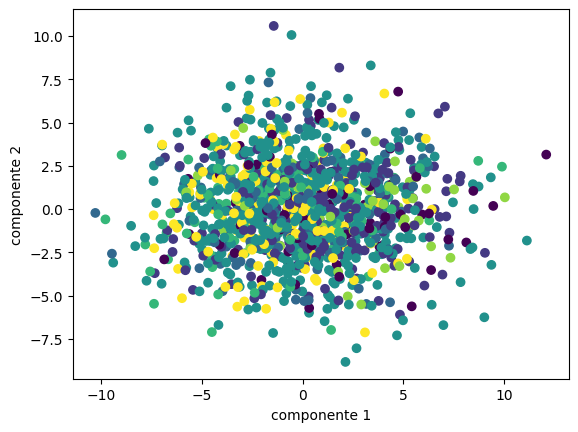

In [7]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
data = scaler.fit_transform(Xdata)
pca = PCA(n_components = 2)
Y2D = pca.fit_transform(data)
plt.scatter(Y2D[:,0],Y2D[:,1],c=y)
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.show()

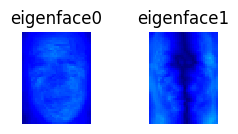

In [9]:
pca = PCA(n_components = 0.99)
Y2D = pca.fit_transform(data)
n_rows = 1
n_cols = 2
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.2))
#resolución imagenes
img_w = 50
img_h = 37

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(abs(pca.components_[index].reshape(img_w,img_h)),
                    vmin=abs(pca.components_).min(), vmax=abs(pca.components_).max(),cmap="jet", interpolation="nearest")
        plt.axis('off')
        plt.title("eigenface" + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [ ]:
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap

In [ ]:
import umap
import umap.plot

red = umap.UMAP(n_components=2,n_neighbors=40, min_dist=0.2)
X_reduced_umap = red.fit_transform(data)
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y, cmap=plt.cm.hot)
plt.grid(True)
plt.show()